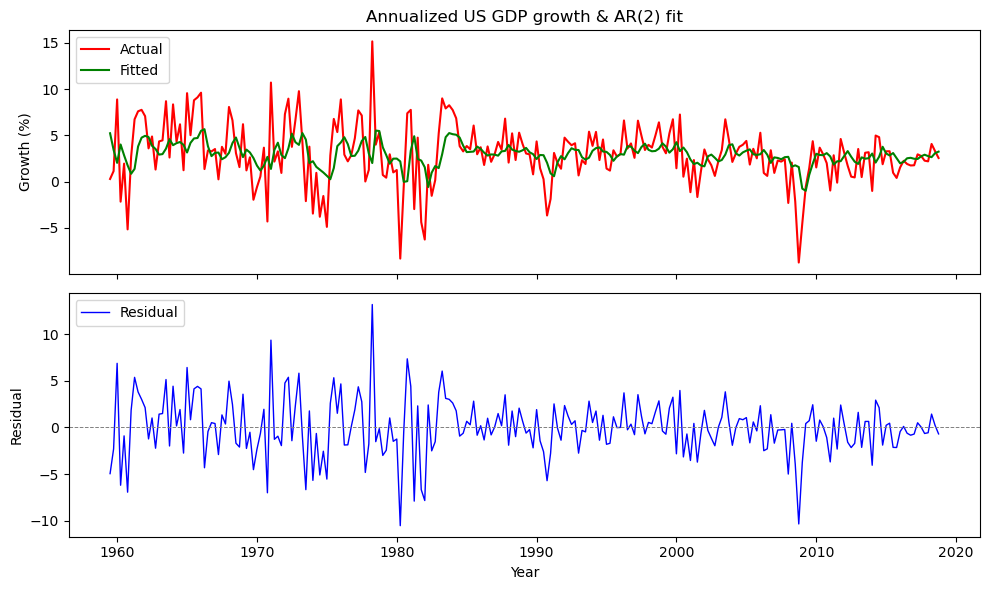

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 1) Load data
df = pd.read_excel("USGDP.xlsx", header=0)
df["QUARTER"] = pd.PeriodIndex(df["QUARTER"], freq="Q")
df = df.set_index("QUARTER").sort_index()

# 2) Compute annualized quarterly growth rate y_t = 400*ln(Y_t / Y_{t-1})
#    Drop the first observation (no growth rate for the very first quarter)
Y = df["RGDP"]
growth = 400 * np.log(Y / Y.shift(1))
growth = growth.dropna()

# 3) Build AR(2) design matrix and estimate by OLS
X = pd.DataFrame({
    "const": 1.0,
    "y_lag1": growth.shift(1),
    "y_lag2": growth.shift(2)
}).dropna()
y = growth.loc[X.index]

ols_res = sm.OLS(y, X).fit()

# 4) Extract fitted values & residuals
fitted = ols_res.fittedvalues
resid  = ols_res.resid

# 5) Convert index for plotting
#    (Periods → actual timestamps so matplotlib can treat them as dates)
t = y.index.to_timestamp()

# 6) Make the two–panel plot
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1, figsize=(10, 6), sharex=True,
    gridspec_kw={"height_ratios": [1, 1]}
)

# Top panel: Actual vs Fitted
ax_top.plot(t, y,      color="red",   label="Actual")
ax_top.plot(t, fitted, color="green", label="Fitted")
ax_top.set_ylabel("Growth (%)")
ax_top.legend(loc="upper left")
ax_top.set_title("Annualized US GDP growth & AR(2) fit")

# Bottom panel: Residuals
ax_bot.plot(t, resid, color="blue", linewidth=1, label="Residual")
ax_bot.axhline(0, linestyle="--", color="gray", linewidth=0.7)
ax_bot.set_ylabel("Residual")
ax_bot.set_xlabel("Year")
ax_bot.legend(loc="upper left")

plt.tight_layout()
plt.show()


Sup‐F = 49.54 at break τ = 1984Q1

Estimates at τ̂:
δ₁ = 4.10  (SE 0.24)
δ₂ = 1.89  (SE 0.20)
R² = 0.17


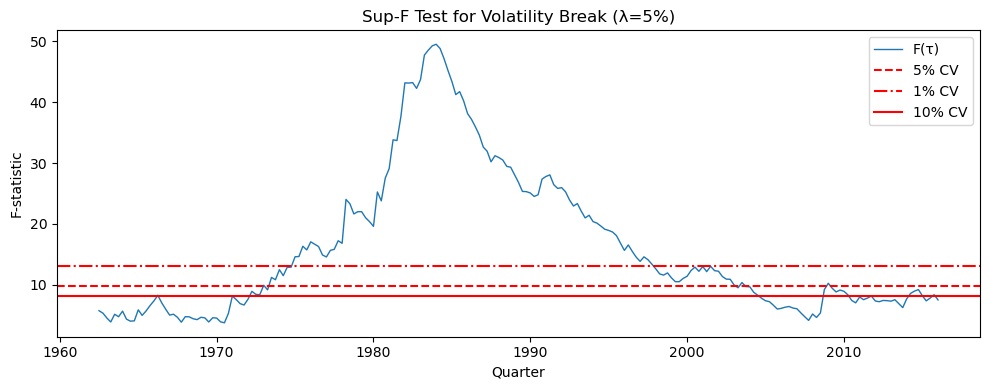

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import f

# 1. Load GDP and compute quarterly growth
df = pd.read_excel("USGDP.xlsx", engine="openpyxl")
df["QUARTER"] = pd.PeriodIndex(df["QUARTER"], freq="Q")
df = df.set_index("QUARTER").sort_index()
Y = df["RGDP"]
y = 400 * np.log(Y / Y.shift(1))
y = y.dropna()

# 2. Fit AR(2) to get residuals
X_ar = pd.DataFrame({
    "const": 1.0,
    "y_lag1": y.shift(1),
    "y_lag2": y.shift(2)
}).dropna()
y_ar = y.loc[X_ar.index]
res_ar = sm.OLS(y_ar, X_ar).fit()
eps = res_ar.resid

# 3. Construct z_t = sqrt(pi/2)*|eps_t|
z = pd.Series(np.sqrt(np.pi/2)*np.abs(eps), index=eps.index)
T = len(z)

# 4. Sup‐F over central 90%
start = int(np.ceil(0.05 * T))
end   = int(np.floor(0.95 * T))

cands = np.arange(start, end+1)
F_stats = np.empty_like(cands, dtype=float)

# Precompute SSR of restricted (just-means) model
z_mean = z.mean()
SSR_r  = np.sum((z - z_mean)**2)

for i, pos in enumerate(cands):
    # break at the pos-th point of z
    tau = z.index[pos]
    D1  = (z.index <= tau).astype(int)
    D2  = 1 - D1
    design = pd.DataFrame({"D1": D1, "D2": D2}, index=z.index)

    # unrestricted SSR
    res_ur  = sm.OLS(z, design).fit()
    SSR_ur = np.sum(res_ur.resid**2)

    # SSR‐based F with df1=1, df2=T−2
    num = (SSR_r - SSR_ur) / 1
    den = SSR_ur / (T - 2)
    F_stats[i] = num / den

# locate Sup‐F
imax    = F_stats.argmax()
supF    = F_stats[imax]
tau_hat = z.index[cands[imax]]
print(f"Sup‐F = {supF:.2f} at break τ = {tau_hat}")

# 5. Re‐estimate at τ̂ for δ1, δ2
D1   = (z.index <= tau_hat).astype(int)
D2   = 1 - D1
model = pd.DataFrame({"D1":D1, "D2":D2}, index=z.index)
res_f = sm.OLS(z, model).fit()

d1, d2   = res_f.params
se1, se2 = res_f.bse
print("\nEstimates at τ̂:")
print(f"δ₁ = {d1:.2f}  (SE {se1:.2f})")
print(f"δ₂ = {d2:.2f}  (SE {se2:.2f})")
print(f"R² = {res_f.rsquared:.2f}")

# 6. Critical values (Andrews 1993, λ=0.05)
cv05, cv01 = 9.84, 13.01

# 7. Plot Sup‐F curve
fig, ax = plt.subplots(figsize=(10,4))
dates = z.index[cands].to_timestamp()

ax.plot(dates, F_stats, lw=1, label="F(τ)")
ax.axhline(cv05, color="red", ls="--", label="5% CV")
ax.axhline(cv01, color="red", ls="-.", label="1% CV")
ax.axhline(8.19, color="red", label="10% CV")

ax.set_title("Sup‐F Test for Volatility Break (λ=5%)")
ax.set_xlabel("Quarter")
ax.set_ylabel("F‐statistic")
ax.legend()

plt.tight_layout()
plt.show()
